xy:  (194, 120, 394, 320)
xy:  (223, 123, 423, 323)
xy:  (234, 124, 434, 324)
xy:  (236, 124, 436, 324)
xy:  (235, 124, 435, 324)
xy:  (236, 124, 436, 324)
xy:  (234, 124, 434, 324)
xy:  (230, 125, 430, 325)
xy:  (225, 124, 425, 324)
xy:  (218, 122, 418, 322)
xy:  (214, 120, 414, 320)
xy:  (212, 118, 412, 318)
xy:  (211, 116, 411, 316)
xy:  (215, 116, 415, 316)
xy:  (219, 117, 419, 317)
xy:  (225, 118, 425, 318)
xy:  (230, 120, 430, 320)
xy:  (232, 122, 432, 322)
xy:  (233, 123, 433, 323)
xy:  (235, 124, 435, 324)
xy:  (236, 125, 436, 325)
xy:  (237, 127, 437, 327)
xy:  (237, 128, 437, 328)
xy:  (238, 130, 438, 330)
xy:  (239, 130, 439, 330)
xy:  (240, 131, 440, 331)
xy:  (239, 131, 439, 331)
xy:  (239, 133, 439, 333)
xy:  (239, 134, 439, 334)
xy:  (239, 133, 439, 333)
xy:  (239, 134, 439, 334)
xy:  (240, 134, 440, 334)
xy:  (241, 134, 441, 334)
xy:  (242, 134, 442, 334)
xy:  (243, 133, 443, 333)
xy:  (245, 132, 445, 332)
xy:  (247, 132, 447, 332)
xy:  (249, 132, 449, 332)
xy:  (252, 1

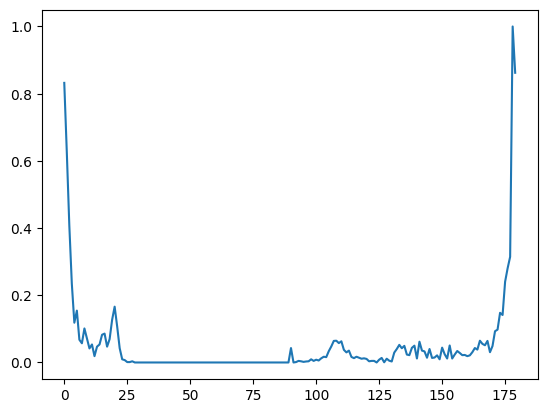

: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import os

x1, y1, x2, y2 = 50, 50, 100, 100
def center_of_mass(backproj):
    x, y = np.meshgrid(np.arange(backproj.shape[1]), np.arange(backproj.shape[0]))

    x_t = np.sum(x * backproj) / np.sum(backproj)
    y_t = np.sum(y * backproj) / np.sum(backproj)

    return x_t, y_t

def first_frame(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV) 
    hue = hsv[:,:,0]
    backproj = roi_hist[hue]
    x_t, y_t = center_of_mass(backproj)
    return x_t, y_t

def other_frames(bgr, prev_xy):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV) 
    hue = hsv[:,:,0]
    backproj = roi_hist[hue]

    backproj = backproj[prev_xy[1]:prev_xy[3], prev_xy[0]:prev_xy[2]]
    cv2.imshow('bgr', backproj)
    print("xy: ", prev_xy)
    tmp_x_t, tmp_y_t = center_of_mass(backproj)
    
    x_t = int(prev_xy[0] + tmp_x_t)
    y_t = int(prev_xy[1] + tmp_y_t)
    return x_t, y_t


plt.ion()
def clear(): return os.system('cls')


clear()
plt.close('all')


# Read in the image
image = cv2.imread('cv02_vzor_hrnecek.bmp')

# convert to HSV
HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# extract the Hue channel
Hue = HSV[:,:,0]

# search for the 

# histogram of Hue

roi_hist, _ = np.histogram(Hue, 180, (0, 180))
# normalize the histogram
roi_hist = roi_hist / np.max(roi_hist)
# plot the histogram
plt.plot(roi_hist)
plt.savefig('cv02_hist.png')

cap = cv2.VideoCapture('cv02_hrnecek.mp4')

first = True
while True:
    ret, bgr = cap.read()
    if not ret:
        break
    

    if first:
        x_t, y_t = first_frame(bgr)
        first = False
    else:
        x_t, y_t = other_frames(bgr, prev_xy)
   

    # draw a rectangle around the center of mass  based on x1, y1, x2, y2
    x1_t = abs(int(x_t - x1 * 2))
    y1_t = abs(int(y_t - y1 * 2))
    x2_t = abs(int(x_t + x2))
    y2_t = abs(int(y_t + y2))
    prev_xy = (x1_t, y1_t, x2_t, y2_t)
    cv2.rectangle(bgr, (x1_t, y1_t), (x2_t, y2_t), (0, 255, 0), 2)
    

    cv2.imshow('img', bgr)
    
    key = 0xFF & cv2.waitKey(30)
    if key == 27: 
        break

#cv2.destroyAllWindows()
